In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.multioutput import MultiOutputClassifier

import xgboost as xgb

# Next two only necessary if target classes are imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

pd.set_option("display.max_columns", 50)
%matplotlib inline

random_state = 1232022

### Importing the data

Because this dataset is part of a competition and a train-test split has already been performed, we'll treat the training data as the entire dataset. That way, we can perform our own train-test split, and, subsequently, we'll be able to acquire test scores of our own without necessarily having to submit to the competition. However, if at any point we're satisfied with a model, we can use that model to make predictions on the competition's original test data and submit those predictions to the competition if we so wish. As such, we'll import the competition's testing data as 'y_test_comp'.

We'll also combine our X and y into a single dataframe in case we need it for EDA, graphs, cleaning or the like.

In [7]:
X = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
y = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')

df = pd.concat([X, y], axis=1)

y_test_comp = pd.read_csv('data/test_set_features.csv')

df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


We'll first check to see if the classes are imbalanced.

In [8]:
print(y['h1n1_vaccine'].value_counts())
print(y['seasonal_vaccine'].value_counts())

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64
0    14272
1    12435
Name: seasonal_vaccine, dtype: int64


It looks as though the seasonal vaccine classes are very balanced, while the H1N1 vaccine classes are less so, with the minority class comprising about 20% of the samples. This is likely not a problem though, so we won't do anything about it for now.

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

### To Pipeline? Or not to Pipeline?

For now, while exploring and experimenting with the data, we'll do things manually. Once we've settled on some models and cleaning strategies, we'll refactor the code into a pipeline.

# First Model: Basic Logistic Regression

To begin, we'll fit a basic logistic regression to the data. The only thing we'll do to prepare the data is to impute missing values (since most categories, including the numeric ones, are categorical, we'll go with the mode), one-hot encode the non-numeric columns, and scale the numeric columns. But first, a train-test split!

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state)

In [175]:
y_train_h1n1 = y_train.iloc[:,0]
y_train_ssnl =y_train.iloc[:,1]

y_test_h1n1 = y_test.iloc[:,0]
y_test_ssnl =y_test.iloc[:,1]

## Preprocessing

In [176]:
numeric_columns = list(X.columns[X.dtypes == 'float64'].values)
obj_columns = list(X.columns[X.dtypes == 'object'].values)

### Simple Imputer

In [177]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputer.fit(X_train)

X_train_imp = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

### One Hot Encoder

In [178]:
X_train_obj = X_train_imp[obj_columns]
X_test_obj = X_test_imp[obj_columns]

ohe = OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)

X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_obj), columns=ohe.get_feature_names(), index=X_train_obj.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_obj), columns=ohe.get_feature_names(), index=X_test_obj.index)

X_train_ohe = pd.concat([X_train_imp[numeric_columns], X_train_ohe], axis=1)
X_test_ohe = pd.concat([X_test_imp[numeric_columns], X_test_ohe], axis=1)

### Standard Scaler

In [179]:
ss = StandardScaler()

X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_ohe), columns=X_train_ohe.columns, index=X_train_ohe.index)
X_test_scaled = pd.DataFrame(ss.transform(X_test_ohe), columns=X_test_ohe.columns, index=X_test_ohe.index)

## Fitting the model

There is a class called MultiOutputClassifier that we could use here that would run regressions for both class labels at the same time, but, even though it's convenient for training, it can be slightly less convenient for scoring and analyzing, so for every model we fit for the H1N1 vaccine, we'll fit a second model for the seasonal flu vaccine as well.

In [180]:
log_reg_h1n1 = LogisticRegression()
log_reg_ssnl = LogisticRegression()

log_reg_h1n1.fit(X_train_scaled, y_train_h1n1)
log_reg_ssnl.fit(X_train_scaled, y_train_ssnl);

### Now we'll score it and plot a confusion matrix

In [181]:
y_hat_h1n1 = log_reg_h1n1.predict(X_test_scaled)
y_hat_ssnl = log_reg_ssnl.predict(X_test_scaled)

In [182]:
cf_matrix_h1n1 = confusion_matrix(y_test_h1n1, y_hat_h1n1)
cf_matrix_ssnl = confusion_matrix(y_test_ssnl, y_hat_ssnl)

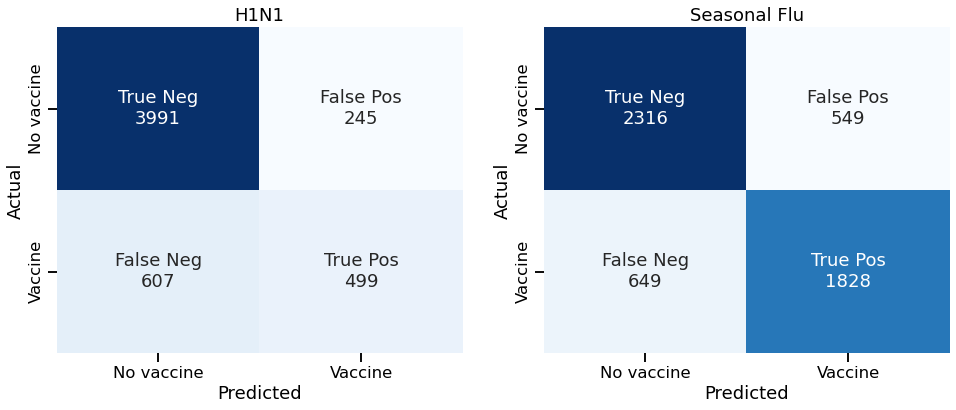

In [183]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
categories = ['No vaccine', 'Vaccine']

group_counts_1 = ['{0:0.0f}'.format(value) for value in cf_matrix_h1n1.flatten()]
labels_1 = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts_1)]
labels_1 = np.asarray(labels_1).reshape(2,2)

group_counts_2 = ['{0:0.0f}'.format(value) for value in cf_matrix_ssnl.flatten()]
labels_2 = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts_2)]
labels_2 = np.asarray(labels_2).reshape(2,2)

sns.set_context('talk')
fig, (ax1, ax2)= plt.subplots(figsize=(16,6), ncols=2)

sns.heatmap(cf_matrix_h1n1, annot=labels_1, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax1)
ax1.set_ylabel('Actual')
ax1.set_yticklabels(ax1.get_yticklabels(), va="center")
ax1.set_xlabel('Predicted')
ax1.set_title('H1N1')

sns.heatmap(cf_matrix_ssnl, annot=labels_2, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax2)
ax2.set_ylabel('Actual')
ax2.set_yticklabels(ax2.get_yticklabels(), va="center")
ax2.set_xlabel('Predicted')
ax2.set_title('Seasonal Flu');

In [184]:
print(f'Recall for H1N1:            {recall_score(y_test_h1n1, y_hat_h1n1)}')
print(f'Recall for seasonal flu:    {recall_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'Precision for H1N1:         {precision_score(y_test_h1n1, y_hat_h1n1)}')
print(f'Precision for seasonal flu: {precision_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'Accuracy for H1N1:          {accuracy_score(y_test_h1n1, y_hat_h1n1)}')
print(f'Accuracy for seasonal flu:  {accuracy_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'F1 score for H1N1:          {f1_score(y_test_h1n1, y_hat_h1n1)}')
print(f'F1 score for seasonal flu:  {f1_score(y_test_ssnl, y_hat_ssnl)}\n')
print(f'AUROC for H1N1:             {roc_auc_score(y_test_h1n1, y_hat_h1n1)}')
print(f'AUROC for seasonal flu:     {roc_auc_score(y_test_ssnl, y_hat_ssnl)}')

Recall for H1N1:            0.4511754068716094
Recall for seasonal flu:    0.7379895034315704

Precision for H1N1:         0.6706989247311828
Precision for seasonal flu: 0.769036600757257

Accuracy for H1N1:          0.8405091725945338
Accuracy for seasonal flu:  0.775739423436915

F1 score for H1N1:          0.5394594594594594
F1 score for seasonal flu:  0.753193242686444

AUROC for H1N1:             0.6966689121232457
AUROC for seasonal flu:     0.7731832333911779


### Refactor into a pipeline

Now that we've got a working model with our cleaning steps mostly sorted out, we'll build a pipeline. We'll also code some of our graphing and scoring steps as functions so we can easily spit out several metrics for each model.

In [220]:
preprocessor = Pipeline([('imp', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                         ('ohe', OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)),
                         ('ss', StandardScaler()),
                         ('lr', LogisticRegression())])

In [219]:
log_reg_h1n1 = LogisticRegression()
log_reg_ssnl = LogisticRegression()

In [222]:
preprocessor.fit_transform(X_train)
#preprocessor.transform(X_test)



ValueError: too many values to unpack (expected 2)

In [213]:
numeric_transformer = Pipeline(
    steps=[("imputer", 
                SimpleImputer(missing_values=np.nan, strategy="most_frequent", 
                add_indicator=True)),
           ("scaler", StandardScaler())]
)


categorical_transformer = Pipeline(
    steps=[("imputer", 
                SimpleImputer(missing_values=np.nan, strategy="most_frequent", 
                add_indicator=True)),
          'ohe', OneHotEncoder(handle_unknown="ignore")]

)

preprocessor = ColumnTransformer(
    transformers=[
        ('omni', omni_transformer, numeric_columns+obj_columns),
        ("num", numeric_transformer, numeric_columns),
        ("cat", categorical_transformer, obj_columns),
    ]
)

TypeError: 'OneHotEncoder' object is not iterable

In [198]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

ohe = OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)

ss = StandardScaler()

cat_transformer = ColumnTransformer(transformers=[("ohe", ohe, obj_columns)], remainder="passthrough")

preprocessor = Pipeline(
    steps=[
        ('imputer', imputer),
        ('transformer', cat_transformer),
        ('scaler', ss)])